Step 18 (Speical Topic 2): Phase-field Method
----
***

In this step, we will employ the phase-field method to address multiphase flow problems, specifically those involving interactions between different phases such as liquid, gas, and solid. The key to this method is the use of an order parameter $ p $ to distinguish the interfaces between these phases. In our notation, $ p = 1 $ represents the solid phase and $ p = 0 $ the liquid phase, with values between 0 and 1 indicating the phase interface. We will apply this phase-field method to simulate the formation of a snowflake from supercooled water, as described in the research by Kobayashi et al. ([Kobayashi .et al](https://www.sciencedirect.com/science/article/abs/pii/016727899390120P)). The governing equation for the order parameter field is derived by minimizing the total free energy, based on the Ginzburg-Landau type free energy theory.





Ginzburg-Landau type free energy: 

\begin{align*}
\phi(p,m) &= \int \frac{1}{2} \epsilon (-\nabla p)^2 |\nabla p|^2 + F(p,m) dr \\
F(p,m) &= \frac{1}{4}p^4 - (\frac{1}{2}-\frac{1}{3}m)p^3 + (\frac{1}{4}-\frac{1}{2}m)p^2
\end{align*}

where $p$ is order parameter at the position $r$ and the time $t$, and $m$ is a model parameter that determines the profile of double-well potential $F$, which gives a thermodynamical driving force. [Kobayashi .et al](https://www.sciencedirect.com/science/article/abs/pii/016727899390120P) take it as a function of non-dimensionalized temperature $T$:

$$ m(T)= \frac{\alpha}{\pi} tan^{-1} [\gamma (T_e - T)] $$ 

where $T_e$ is an equilibrium temperature, $\alpha$ is a positive constant satisfying $\alpha<1$. $\epsilon$ is small parameter which determines the thickness of solid/liquid interface. And anisotropy can be introduced by assuming $\epsilon$ depends on the direction of the outer normal vector at the interface. [Kobayashi .et al](https://www.sciencedirect.com/science/article/abs/pii/016727899390120P) take the form $\epsilon = \epsilon(\theta) = \bar{\epsilon} \sigma(\theta)$, where $\theta$ is an angle between the outer normal vector $-\nabla p$ and the positive direction of the x-axis, $\bar{\epsilon}$ is a mean value of $\epsilon$, and $\sigma(\theta)$ represents anisotripy:

$$ \sigma(\theta) = 1 + \delta cos[j(\theta-\theta_0)] $$

where the parameter $\delta$ means the strength of anisotropy and $j$ is a mode number of anisotropy. Then from the formula $ \tau \frac{\partial p}{\partial t} = -\frac{\delta \phi}{\partial p} $ we obtain the evolution equation for the order parameter:

$$ 
\tau \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} (\epsilon \epsilon' \frac{\partial p}{\partial y}) + \frac{\partial}{\partial y} (\epsilon \epsilon' \frac{\partial p}{\partial x}) +
\nabla \cdot (\epsilon^2 \nabla p) + p(1-p)(p-\frac{1}{2}+m)
$$
In order to make the simulation more realistic, a small noise term $ ap(1-p)\chi $ is added to the interface, where $a$ is an amplitude of the noise and $\chi$ is a random number on $[-\frac{1}{2}, \frac{1}{2}]$.



The equation for non-dimensionalized temperature $T$ is derived from the conservation law of enthalpy as:

$$ \frac{\partial T}{\partial t} = \nabla^2 T + K \frac{\partial p}{\partial t} $$ 

where $K$ is a dimensionless latent heat. 

Discretization
***


For the order parameter evolution equation, the 1st term on right hand side of (part1):
$$
-\frac{\partial}{\partial x} (\epsilon \epsilon' \frac{\partial p}{\partial y}) = -
\frac{
\epsilon^n_{i+1,j} \cdot \epsilon'^n_{i+1,j} \cdot \frac{p^n_{i+1,j+1}-p^n_{i+1,j-1}}{2\Delta y} -
\epsilon^n_{i-1,j} \cdot \epsilon'^n_{i-1,j} \cdot \frac{p^n_{i-1,j+1}-p^n_{i-1,j-1}}{2\Delta y}
} {2\Delta x}
$$

The 2nd term on right hand side (part2):
$$
\frac{\partial}{\partial y} (\epsilon \epsilon' \frac{\partial p}{\partial x}) = 
\frac{
\epsilon^n_{i,j+1} \cdot \epsilon'^n_{i,j+1} \cdot \frac{p^n_{i+1,j+1}-p^n_{i-1,j+1}}{2\Delta x} -
\epsilon^n_{i,j-1} \cdot \epsilon'^n_{i,j-1} \cdot \frac{p^n_{i+1,j-1}-p^n_{i-1,j-1}}{2\Delta x}
} {2\Delta y}
$$

The 3nd term on right hand (part3 & part4):


\begin{align*}
\nabla \cdot (\epsilon^2 \nabla p) &= \nabla (\epsilon^2) \cdot \nabla p + \epsilon^2 \cdot \nabla^2 p \\
\nabla (\epsilon^2) \cdot \nabla p &= \frac{(\epsilon^2)^n_{i+1,j}-(\epsilon^2)^n_{i-1,j}} {2\Delta x} \cdot \frac{p^n_{i+1,j}-p^n_{i-1,j}} {2\Delta x} + 
                                      \frac{(\epsilon^2)^n_{i,j+1}-(\epsilon^2)^n_{i,j-1}} {2\Delta y} \cdot \frac{p^n_{i,j+1}-p^n_{i,j-1}} {2\Delta y} \\
\epsilon^2 \cdot \nabla^2 p &= \epsilon^2 \cdot (\frac{p^n_{i+1,j} + p^n_{i-1,j} - 2p^n_{i,j}} {\Delta x^2} + \frac{p^n_{i,j+1}+p^n_{i,j-1}-2p^n_{i,j}} {\Delta y^2})
\end{align*}


For the temprature evolution equation,
$$
T^{n+1}_{i,j} = T^n_{i,j} + (\frac{T^n_{i+1,j} + T^n_{i-1,j} - 2T^n_{i,j}} {\Delta x^2} + \frac{T^n_{i,j+1}+T^n_{i,j-1}-2T^n_{i,j}} {\Delta y^2}) \Delta t + K(p^{n+1}_{i,j}-p^n_{i,j})
$$

In [1]:
import os
import jax
import yaml
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.numpy import pi
from functools import partial
from jax import config
config.update("jax_enable_x64", True)

In [2]:
def yaml_parse(yaml_filepath):     
    with open(yaml_filepath) as f:
        args = yaml.load(f, Loader=yaml.FullLoader)
        print(f"YAML parameters:")
        print(yaml.dump(args, default_flow_style=False))
    return args

In [3]:
case_name = 'ice'
work_path = os.getcwd()
case_path = work_path + os.sep + case_name
print(case_path)
if not os.path.exists(case_path):
    os.makedirs(case_path)
    print(f"Directory '{case_name}' created at work_path.")
else:
    print(f"Directory '{case_name}' already exists at work_path.")
    for file in os.listdir(case_path):
        f = case_path + os.sep + file
        if os.path.isfile(f):
            os.remove(f)
            
args = yaml_parse(os.path.join(work_path, '%s.yaml' %(case_name))) 

/mnt/c/Working fold/Courses/CFD/python code/Konayashi_1993-main/jax_version/ice
Directory 'ice' already exists at work_path.
YAML parameters:
J: 6
K: 1.2
T_eq: 1.0
a: 0.01
alpha: 0.9
delta: 0.04
dt: 0.0002
eps_bar: 0.01
gamma: 10.0
hx: 0.03
hy: 0.03
nx: 300
ny: 300
t_OFF: 0.28
tau: 0.0003



In [4]:
dt = args['dt']
t_OFF = args['t_OFF']
hx = args['hx']
hy = args['hy']
nx = args['nx']
ny = args['ny']
K = args['K']
tau = args['tau']
T_eq = args['T_eq']
gamma = args['gamma']
alpha = args['alpha']
a = args['a']
J = args['J']
delta = args['delta']
eps_bar = args['eps_bar']

t = 0.
nIter = int(t_OFF/dt)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


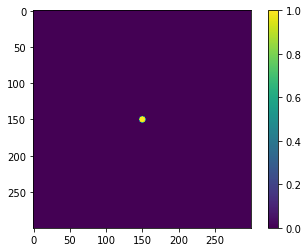

In [5]:
# Initializing
T = np.zeros((nx,ny))
p = np.zeros((nx,ny))
theta = np.zeros((nx,ny))
p_x = np.zeros((nx,ny))
p_y = np.zeros((nx,ny))
eps = np.zeros((nx,ny))
eps_prime = np.zeros((nx,ny))
eps2_x = np.zeros((nx,ny))
eps2_y = np.zeros((nx,ny))

'''circle'''
i, j = onp.meshgrid(onp.arange(nx), onp.arange(ny))
mask =  ((i - nx/2.)**2 + (j - ny/2.)**2) < 20.
p = p.at[mask].set(1.)
'''hexagon'''
# x0, y0, L = nx//2, ny//2, 10
# lk = -1 / np.sqrt(3)
# b0 = y0-L+x0/np.sqrt(3)
# b1 = L+y0+x0/np.sqrt(3)
# b2 = y0-L-x0/np.sqrt(3)
# b3 = y0+L-x0/np.sqrt(3)
# for i in range(nx):
#     for j in range(ny):
#         if i>=x0-L and i<=x0+L and j<=b1+lk*i and j>=b2-lk*i and j<=b3-lk*i and j>=b0+lk*i:
#             p[i,j] = 1.
            
plt.imshow(p, cmap='viridis')
plt.colorbar()
plt.show()

In [6]:
@partial(jax.jit, static_argnums=(1,2))
def grad(m, dx, dy): # Central differecing
    m_neg_y = np.concatenate((m[:, :1], m[:, :-1]), axis=1)
    m_pos_y = np.concatenate((m[:, 1:], m[:, -1:]), axis=1)
    m_neg_x = np.concatenate((m[:1, :], m[:-1, :]), axis=0)
    m_pos_x = np.concatenate((m[1:, :], m[-1:, :]), axis=0)
    
    f_x = (m_pos_x - m_neg_x) / 2. /dx
    f_y = (m_pos_y - m_neg_y) / 2. /dy
    return f_x, f_y

@partial(jax.jit, static_argnums=(1,2))
def laplace(m, hx, hy): # Central differecing
    m_neg_y = np.concatenate((m[:, :1], m[:, :-1]), axis=1)
    m_pos_y = np.concatenate((m[:, 1:], m[:, -1:]), axis=1)
    m_neg_x = np.concatenate((m[:1, :], m[:-1, :]), axis=0)
    m_pos_x = np.concatenate((m[1:, :], m[-1:, :]), axis=0)
    return (m_neg_x + m_pos_x - 2.*m)/hx**2 + (m_neg_y + m_pos_y - 2.*m)/hy**2

In [7]:
@partial(jax.jit)
def get_theta(angle, f_x, f_y):
    theta = np.zeros_like(angle)
    mask = (f_x == 0) & (f_y > 0)
    theta = np.where(mask, .5*np.pi, theta)
    mask = (f_x == 0) & (f_y < 0)
    theta = np.where(mask, 1.5*np.pi, theta)
    mask = (f_x > 0) & (f_y < 0)
    theta = np.where(mask, 2*np.pi + np.arctan(f_y/f_x), theta)
    mask = (f_x > 0) & (f_y > 0)
    theta = np.where(mask, np.arctan(f_y/f_x), theta)
    mask = (f_x < 0)
    theta =  np.where(mask, np.pi + np.arctan(f_y/f_x), theta)
    return theta

@partial(jax.jit)
def get_eps(angle):
    return eps_bar*(1 + delta*np.cos(J*angle)), -eps_bar*J*delta*np.sin(J*angle)

In [8]:
@partial(jax.jit, static_argnums=(0,1))
def phase_field(dx, dy, eps, eps_prime, p_x, p_y, p, T):    
    part1, _ = grad(eps*eps_prime*p_y, dx, dy)
    _, part2 = grad(eps*eps_prime*p_x, dx, dy)
    part3 = eps2_x*p_x + eps2_y*p_y
    part4 = eps**2 * laplace(p, dx, dy)
    
    m = alpha / np.pi * np.arctan(gamma*(T_eq-T))
    term1 = -part1 + part2 + part3 + part4
    term2 = p*(1-p)*(p-0.5+m)
    chi = jax.random.uniform(jax.random.PRNGKey(0), shape=p.shape) - 0.5
    noise =  a * p * (1-p) * chi
    
    p_new = p + dt/tau*(term1 + term2 + noise)
    #mask = (p <= 0.9) & (p >= 0.1)
    return p_new #np.where(mask, p_new+noise, p_new)

In [9]:
@partial(jax.jit)
def T_field(T, d_eta):
    return T + dt*laplace(T,hx,hy) + K*d_eta

In [10]:
@partial(jax.jit)
def zero_flux_BC(arr):
    arr = arr.at[0,:].set(arr[1,:])
    arr = arr.at[:,0].set(arr[:,1])
    arr = arr.at[-1,:].set(arr[-2,:])
    arr = arr.at[:,-1].set(arr[:,-2])
    return arr

In [11]:
for i in range(nIter):
    p_x, p_y = grad(p, hx, hy)
    theta = get_theta(theta, p_x, p_y)
    eps, eps_prime = get_eps(theta)
    eps2_x, eps2_y = grad(eps**2, hx, hy)
    
    p_new = phase_field(hx, hy, eps, eps_prime, p_x, p_y, p, T) 
    p_new = zero_flux_BC(p_new)
    d_p = p_new - p
    
    T_new = T_field(T, d_p)
    T_new = zero_flux_BC(T_new)
    
    p = p_new
    T = T_new
    
    if (i+1) % 20 == 0:
        plt.figure(figsize=(10, 8))
        plt.imshow(p, cmap='viridis')
        plt.colorbar()
        plt.savefig(case_path + os.sep + "%s_%f.png" %(case_name, t))  
        #plt.show()
        plt.close()
        
#     if (i+1) % 1000 == 0: 
#         print(t)
        
    t += dt
print('t=', t)

t= 0.2800000000000018


In [12]:
case_path + os.sep + "%s_%f.png" %(case_name, t)

'/mnt/c/Working fold/Courses/CFD/python code/Konayashi_1993-main/jax_version/ice/ice_0.280000.png'

In [13]:
import imageio.v2 as imageio
# Collecting filenames
filenames = []
for filename in os.listdir(case_path):
    if filename.startswith(case_name) and filename.endswith(".png"):
        full_path = os.path.join(case_path, filename)
        filenames.append(full_path)

# Sorting filenames - Important if 't' increments regularly
# This sort works if 't' has a fixed number of decimal places
filenames.sort()

# Create an animation from the saved images
animation_path = os.path.join(case_path, f"{case_name}_animation.gif")
with imageio.get_writer(animation_path, mode='I', loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# The saved animation path
print(f"Animation saved at: {animation_path}")

Animation saved at: /mnt/c/Working fold/Courses/CFD/python code/Konayashi_1993-main/jax_version/ice/ice_animation.gif


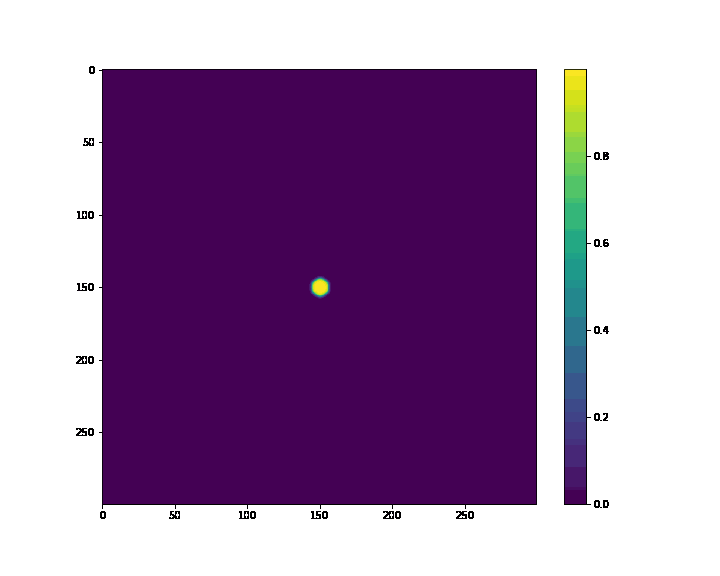

In [14]:
from IPython.display import Image, display

# Path to your GIF file
gif_path = animation_path  # Replace with your actual file path

# Display the GIF in Jupyter Notebook
display(Image(filename=gif_path))